# CMPINF0010 Final Project
## Project Idea: Determine which neighborhood is best suited to being car-free
### Analysis in this notebook done by Justin Tometich, jut26


Databases used in this analysis:


https://data.wprdc.org/dataset/2010-census-tracts

specifically the GeoJSON file: https://data.wprdc.org/dataset/4699bc46-8a74-44ed-9bef-f22dd595a964/resource/e51e4102-5aa1-4ef7-9f08-76fded66cb58/download/pittsburghpa2010-census-tracts.geojson
- using this url instead of the neighborhoods data from the lab lesson allows for matching to both GEOIDs and Census Tracts for the 2 below datasets



https://data.wprdc.org/dataset/sidewalk-to-street-walkability-ratio

specifically the Sidewalk Street Ratio 2021/12/01 Blockgroup with GEOID block data csv: https://data.wprdc.org/dataset/853a077d-0a31-4292-8a1d-5d60b530169b/resource/b90ccee1-c0aa-43b9-93e2-8a25e690c393/download/sidewalkstreetratioupload.csv



https://data.wprdc.org/dataset/allegheny-county-walk-scores

specifically the Walk Scores 2014 Data csv: https://data.wprdc.org/dataset/4d3d4324-b32a-4519-b56f-cee2340057bf/resource/682b1df1-a63b-4413-9362-ba077af63baa/download/walkscorect.xls-walk-score-by-ct.csv



In [1]:
import pandas as pd
import geopandas
import numpy as np

# import sidewalk-to-road length ratio from wprdc
# sidewalk_ratios_tract = pd.read_csv("https://data.wprdc.org/dataset/853a077d-0a31-4292-8a1d-5d60b530169b/resource/ab8db07e-09ef-45c4-bad2-f7d32bfc5f26/download/sidewalkstreetratiotract.csv")
# sidewalk_ratios_tract.head()
sidewalk_ratios_geoid = pd.read_csv("https://data.wprdc.org/dataset/853a077d-0a31-4292-8a1d-5d60b530169b/resource/b90ccee1-c0aa-43b9-93e2-8a25e690c393/download/sidewalkstreetratioupload.csv")
sidewalk_ratios_geoid.head()

,GEOID,NAMELSAD,SidewalkStepLFt,StreetLFt,Ratio
0,420030103001,Block Group 1,13392.83310,30315.86390,0.441776
1,420030103002,Block Group 2,31944.47597,20586.79493,1.551697
2,420030103003,Block Group 3,18655.20798,12122.70024,1.538866
3,420030103004,Block Group 4,14456.19616,11567.62831,1.249711
4,420030201001,Block Group 1,43952.94811,24426.52459,1.799394


In [2]:
# import walk scores 2014 data
walk_scores_2014_data = pd.read_csv("https://data.wprdc.org/dataset/4d3d4324-b32a-4519-b56f-cee2340057bf/resource/682b1df1-a63b-4413-9362-ba077af63baa/download/walkscorect.xls-walk-score-by-ct.csv")
walk_scores_2014_data.head()

,Census Tract,Walk Score
0,10300,82
1,20100,100
2,20300,83
3,30500,77
4,40200,71


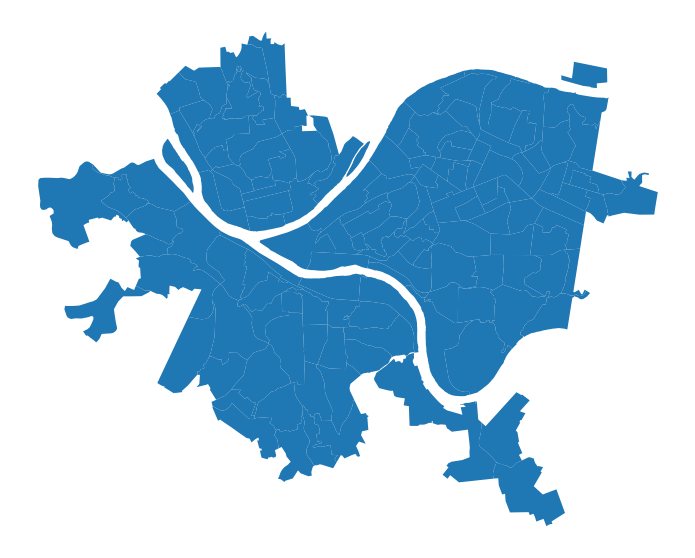

In [3]:
# import census neighborhoods from 2010 census for location data
# link is to a geojson file that geopandas can take directly
census_neighborhoods_2010 = geopandas.read_file("https://data.wprdc.org/dataset/4699bc46-8a74-44ed-9bef-f22dd595a964/resource/e51e4102-5aa1-4ef7-9f08-76fded66cb58/download/pittsburghpa2010-census-tracts.geojson")
census_neighborhoods_2010.plot(figsize=(15, 10)).set_axis_off()

# Neighborhoods by Sidewalk Length:Street Length Ratio

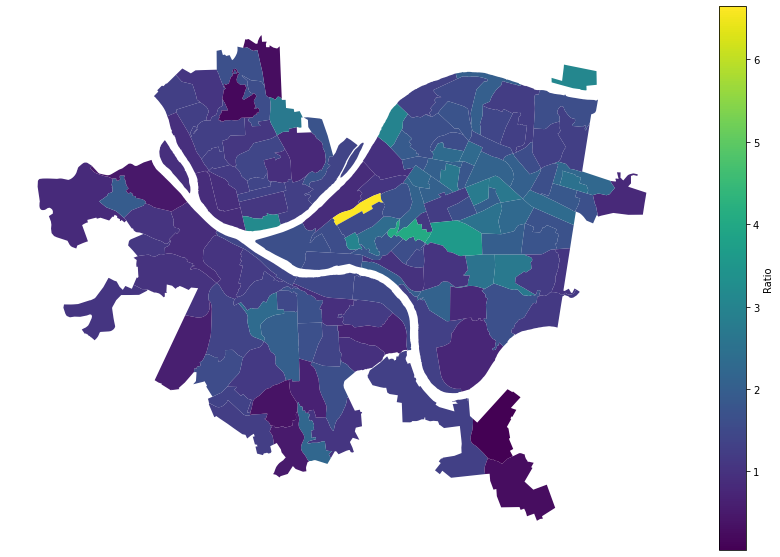

In [45]:
# merge sidewalk ratios GEOID column to census neighborhoods geoid10 column
census_neighborhoods_2010 = geopandas.read_file("https://data.wprdc.org/dataset/4699bc46-8a74-44ed-9bef-f22dd595a964/resource/e51e4102-5aa1-4ef7-9f08-76fded66cb58/download/pittsburghpa2010-census-tracts.geojson")
# apparently the geo id columns from one of these datasets isn't an int, so coerce both
census_neighborhoods_2010["geoid10"] = census_neighborhoods_2010["geoid10"].astype(int)
sidewalk_ratios_geoid["GEOID"] = sidewalk_ratios_geoid["GEOID"].astype(int)
# sidewalk_ratios_geoid["Ratio"] = sidewalk_ratios_geoid["Ratio"].astype("Float64").dropna()

sidewalk_ratios_with_neighborhood = census_neighborhoods_2010.merge(sidewalk_ratios_geoid, how = "left", left_on = "geoid10", right_on = "GEOID")
#sidewalk_ratios_with_neighborhood[["geoid10", "hood", "Ratio"]].head(10)
sidewalk_ratios_with_neighborhood.plot(column = "Ratio", legend = True, legend_kwds={'label': "Ratio"}, figsize=(15, 10)).set_axis_off()

# Neighborhoods by Walk Score (Determined by Walking Distance from Amenities)

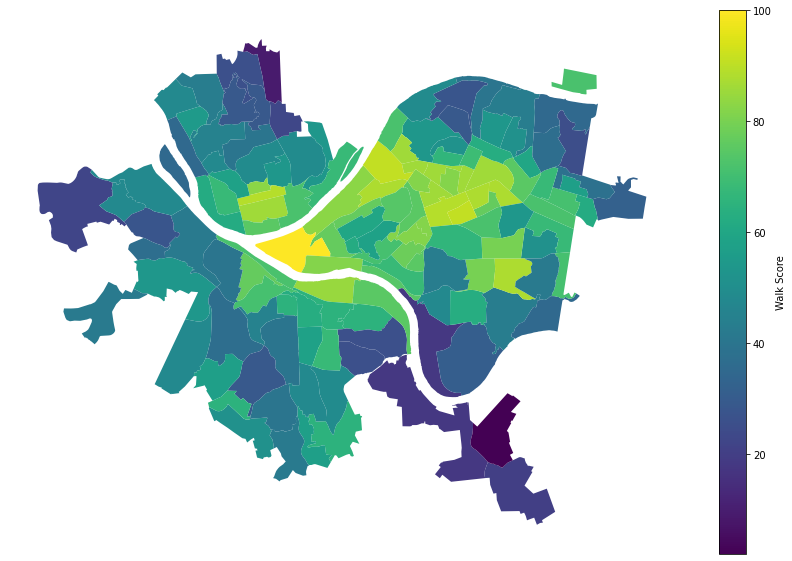

In [38]:
# do a similar merge for walk score data that uses census tracts for locations instead
census_neighborhoods_2010 = geopandas.read_file("https://data.wprdc.org/dataset/4699bc46-8a74-44ed-9bef-f22dd595a964/resource/e51e4102-5aa1-4ef7-9f08-76fded66cb58/download/pittsburghpa2010-census-tracts.geojson")
# census tract values are always 6 digits in census data, but walk scores dataset removes leading 0s such that some are 5 digit
# convert both columns to ints so that these leading 0s don't matter
walk_scores_2014_data["Census Tract"] = walk_scores_2014_data["Census Tract"].astype(int)
census_neighborhoods_2010["tractce10"] = census_neighborhoods_2010["tractce10"].astype(int)

walk_scores_with_neighborhood = census_neighborhoods_2010.merge(walk_scores_2014_data, how = "left", left_on = "tractce10", right_on = "Census Tract")
#walk_scores_with_neighborhood[["tractce10", "hood", "Walk Score"]].head(60)
#walk_scores_with_neighborhood.head(5)
walk_scores_with_neighborhood.plot(column = "Walk Score", legend = True, legend_kwds={'label': "Walk Score"}, figsize=(15, 10)).set_axis_off()

# Walk Scores of Neighborhoods with Sidewalk Ratios >= 2 

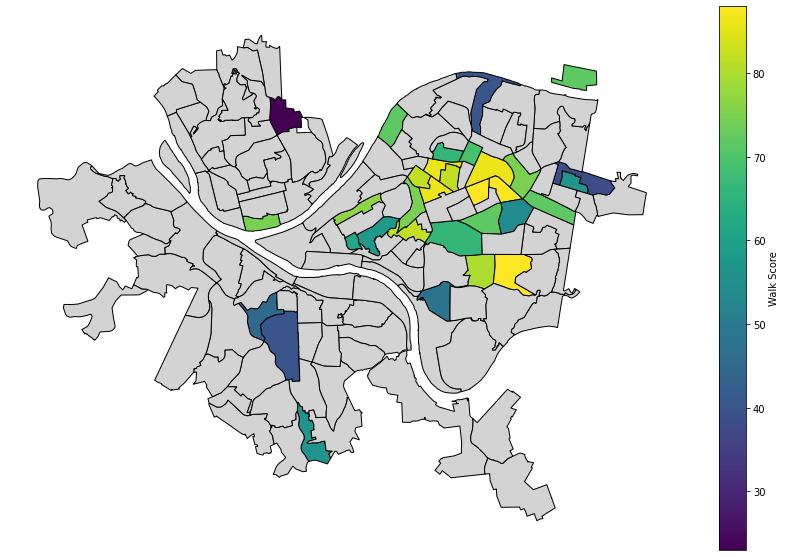

In [37]:
# Further analysis: merge two datasets and then select walk scores where sidewalk ratio is >= 2 (implies that there are sidewalks along every street? how are some ratios as high as 6?)
sidewalk_ratios_with_neighborhood["geoid10"] = sidewalk_ratios_with_neighborhood["geoid10"].astype(int)
walk_scores_with_neighborhood["geoid10"] = walk_scores_with_neighborhood["geoid10"].astype(int)
sidewalks_and_walk_scores_combined = walk_scores_with_neighborhood.merge(sidewalk_ratios_with_neighborhood[["hood", "Ratio", "geoid10"]], how = "left", left_on = "geoid10", right_on = "geoid10")

for index, row in sidewalks_and_walk_scores_combined.iterrows():
    # print(row)
    if row.loc["Ratio"] < 2:
        sidewalks_and_walk_scores_combined.at[index, "Walk Score"] = None

sidewalks_and_walk_scores_combined = geopandas.GeoDataFrame(sidewalks_and_walk_scores_combined)
sidewalks_and_walk_scores_combined.plot(column = "Walk Score", legend = True, legend_kwds={'label': "Walk Score"}, figsize=(15,10), edgecolor="black", missing_kwds={"color": "lightgrey"}).set_axis_off()

In [36]:
sidewalks_and_walk_scores_combined_masked[["hood_x", "Ratio", "Walk Score"]].sort_values("Walk Score", ascending=False).head(10)

,hood_x,Ratio,Walk Score
89,Shadyside,2.778579,88.0
99,Squirrel Hill South,2.719089,88.0
80,Shadyside,2.695575,88.0
124,East Liberty,2.116163,86.0
35,Bloomfield,2.057364,86.0
78,Bloomfield,2.081824,86.0
39,Bloomfield,2.265926,82.0
66,North Oakland,4.045073,82.0
77,Bloomfield,2.700800,82.0
31,Squirrel Hill South,2.560622,80.0


# Top Neighborhood: Tie between Shadyside and Squirrel Hill South